Water Quality category: ['TEMP', 'DO', 'pH', 'TDS', 'SS', 'VSS']
Nutrient category: ['NO2+NO3', 'NH3_N', 'TKN', 'Tot P']
Heavy Metal category (n): 11

=== Category Scores (head) ===
   WQ_category  Nutrient_category  HM_category
0     0.193580          -0.263931     0.439514
1     0.193580          -0.263931     0.439514
2     0.166089          -0.583658    -0.387399
3     0.178632          -0.573048    -0.354194
4     0.286251          -0.611519    -0.035930

=== Category Correlation ===
                   WQ_category  Nutrient_category  HM_category
WQ_category           1.000000          -0.217655     0.306911
Nutrient_category    -0.217655           1.000000     0.269109
HM_category           0.306911           0.269109     1.000000


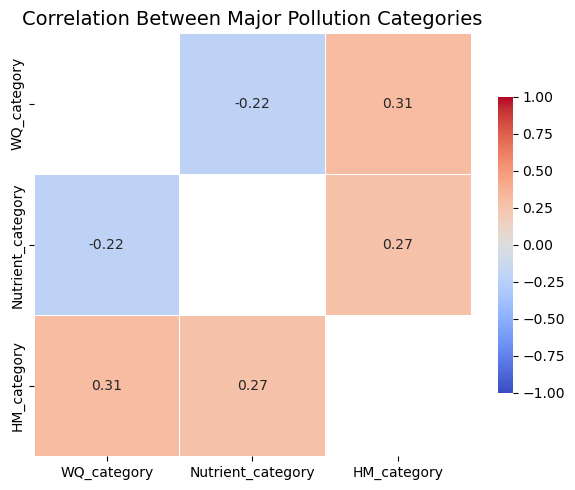

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) load data
df = pd.read_csv("/Users/qianrunchen/Downloads/processedmerged_data.csv", low_memory=False)
df.columns = df.columns.str.strip()

# 2) clean numeric fields (e.g. "<0.002")
def clean_to_float(x):
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("<"):
            x = x[1:].strip()
        x = x.replace(",", "")
        try:
            return float(x)
        except:
            return np.nan
    return x

numeric_candidates = []
for col in df.columns:
    if any(key in col.lower() for key in 
           ["temp","do","ph","no2","nh3","tkn","tot","turb","ss","vss","tds","sol","ll"]):
        numeric_candidates.append(col)

for col in numeric_candidates:
    df[col] = df[col].apply(clean_to_float)

# 3) define pollutant categories
group_wq = [c for c in ["TEMP","DO","pH","TDS","SS","VSS"] if c in df.columns]
group_np = [c for c in ["NO2+NO3","NH3_N","TKN","Tot P"] if c in df.columns]
group_hm = [c for c in df.columns 
            if (("sol" in c.lower()) or (" ll" in c.lower()) or (" tot" in c.lower()))
            and (c not in ["Tot P", "Tota P"])]

print("Water Quality category:", group_wq)
print("Nutrient category:", group_np)
print("Heavy Metal category (n):", len(group_hm))

# 4) standardize (z-score)
df_std = df[group_wq + group_np + group_hm].copy()
for col in df_std.columns:
    df_std[col] = (df_std[col] - df_std[col].mean(skipna=True)) / df_std[col].std(skipna=True)

# 5) compute category scores
df_scores = pd.DataFrame({
    "WQ_category": df_std[group_wq].mean(axis=1),
    "Nutrient_category": df_std[group_np].mean(axis=1),
    "HM_category": df_std[group_hm].mean(axis=1)
})

print("\n=== Category Scores (head) ===")
print(df_scores.head())

# 6) category-to-category correlation
category_corr = df_scores.corr()
print("\n=== Category Correlation ===")
print(category_corr)

# 7) heatmap (hide diagonal)
mask = np.eye(len(category_corr), dtype=bool)

plt.figure(figsize=(6,5))
sns.heatmap(
    category_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Between Major Pollution Categories", fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
# 1) INTERNAL COHESION (within-category correlation)

def internal_cohesion(cols, data):
    if len(cols) < 2:
        return np.nan
    corr_mat = data[cols].corr().abs()
    mask = ~np.eye(len(cols), dtype=bool)
    return corr_mat.values[mask].mean()

internal_wq = internal_cohesion(group_wq, df_std)
internal_np = internal_cohesion(group_np, df_std)
internal_hm = internal_cohesion(group_hm, df_std)

print("\n=== Internal Cohesion (Category Internal Correlation) ===")
print("Water_Quality_Category:", round(internal_wq, 3))
print("Nutrient_Category:", round(internal_np, 3))
print("Heavy_Metal_Category:", round(internal_hm, 3))


# 2) EXTERNAL INFLUENCE (correlation with WQ category)

external_np = df_scores["WQ_category"].corr(df_scores["Nutrient_category"])
external_hm = df_scores["WQ_category"].corr(df_scores["HM_category"])

print("\n=== External Influence on Water Quality (WQ_category) ===")
print("Nutrient_category → WQ_category:", round(external_np, 3))
print("Heavy_Metal_category → WQ_category:", round(external_hm, 3))


# 3) COMBINED IMPACT SCORE (Internal × External)

impact_np = abs(internal_np * external_np)
impact_hm = abs(internal_hm * external_hm)

print("\n=== Combined Impact Scores (Internal × External) ===")
print("Nutrient_category Impact Score:", round(impact_np, 3))
print("Heavy_Metal_category Impact Score:", round(impact_hm, 3))




=== Internal Cohesion (Category Internal Correlation) ===
Water_Quality_Category: 0.232
Nutrient_Category: 0.348
Heavy_Metal_Category: 0.157

=== External Influence on Water Quality (WQ_category) ===
Nutrient_category → WQ_category: -0.218
Heavy_Metal_category → WQ_category: 0.307

=== Combined Impact Scores (Internal × External) ===
Nutrient_category Impact Score: 0.076
Heavy_Metal_category Impact Score: 0.048


In [22]:
# FIND DOMINANT VARIABLE INSIDE EACH CATEGORY


def variable_importance(category_cols, category_score, data):
    results = []
    for col in category_cols:
        r = data[col].corr(category_score)
        results.append((col, r))
    results = pd.DataFrame(results, columns=["Variable", "Correlation_with_CategoryScore"])
    results["AbsCorr"] = results["Correlation_with_CategoryScore"].abs()
    return results.sort_values("AbsCorr", ascending=False)

# Water Quality Category
wq_importance = variable_importance(group_wq, df_scores["WQ_category"], df_std)

# Nutrient Category
np_importance = variable_importance(group_np, df_scores["Nutrient_category"], df_std)

# Heavy Metal Category
hm_importance = variable_importance(group_hm, df_scores["HM_category"], df_std)

print("\n=== Water Quality Category Variable Importance ===")
print(wq_importance)

print("\n=== Nutrient Category Variable Importance ===")
print(np_importance)

print("\n=== Heavy Metal Category Variable Importance (Top 10) ===")
print(hm_importance.head(10))




=== Water Quality Category Variable Importance ===
  Variable  Correlation_with_CategoryScore   AbsCorr
5      VSS                        0.696008  0.696008
4       SS                        0.690477  0.690477
2       pH                        0.646946  0.646946
1       DO                        0.445007  0.445007
3      TDS                        0.394074  0.394074
0     TEMP                       -0.110045  0.110045

=== Nutrient Category Variable Importance ===
  Variable  Correlation_with_CategoryScore   AbsCorr
2      TKN                        0.777675  0.777675
1    NH3_N                        0.744868  0.744868
3    Tot P                        0.710334  0.710334
0  NO2+NO3                        0.626727  0.626727

=== Heavy Metal Category Variable Importance (Top 10) ===
   Variable  Correlation_with_CategoryScore   AbsCorr
8    Ca tot                        0.791272  0.791272
9    Mg tot                        0.778148  0.778148
4    Mn sol                        0.628566 

Water Quality = ['TEMP', 'DO', 'pH', 'TDS', 'SS', 'VSS']
Nutrients = ['NO2+NO3', 'NH3_N', 'TKN', 'Tot P']
Metals = ['As sol', 'Ba tot', 'Cu sol', 'Fe sol', 'Mn sol', 'Ni sol', 'Zn sol', 'Hg LL', 'Ca tot', 'Mg tot'] ...

=== PCA Loadings: Water Quality Category ===
TEMP : -0.535
DO : 0.58
pH : 0.381
TDS : 0.448
SS : 0.132
VSS : 0.121

=== PCA Loadings: Nutrient Category ===
NO2+NO3 : 0.359
NH3_N : 0.57
TKN : 0.59
Tot P : 0.445

=== PCA Loadings: Heavy Metal Category ===
As sol : -0.01
Ba tot : 0.407
Cu sol : 0.03
Fe sol : 0.138
Mn sol : 0.426
Ni sol : 0.045
Zn sol : 0.082
Hg LL : 0.074
Ca tot : 0.534
Mg tot : 0.524
B tot : 0.242


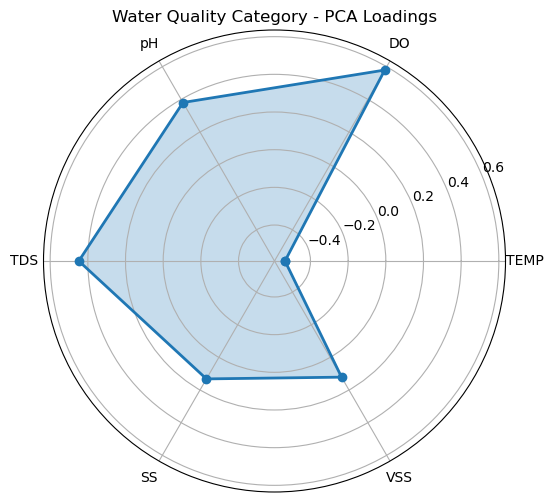

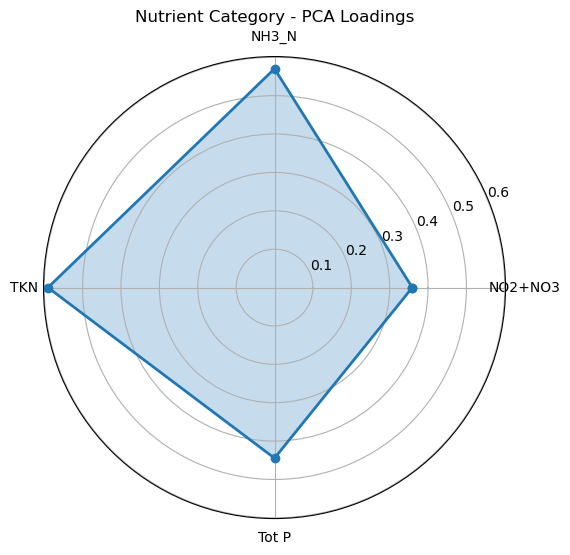

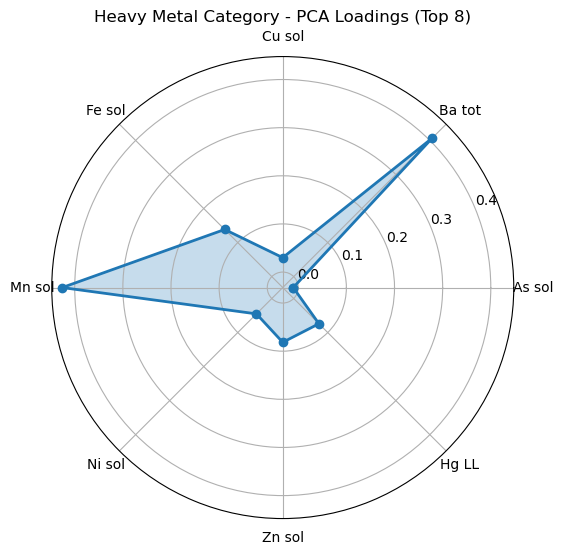

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ===============================
# 0. LOAD & CLEAN DATA
# ===============================
df = pd.read_csv("/Users/qianrunchen/Downloads/processedmerged_data.csv", low_memory=False)
df.columns = df.columns.str.strip()

def clean_to_float(x):
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("<"):
            x = x[1:].strip()
        x = x.replace(",", "")
        try:
            return float(x)
        except:
            return np.nan
    return x

numeric_candidates = [c for c in df.columns 
                      if any(k in c.lower() for k in 
                             ["temp","do","ph","no2","nh3","tkn","tot","ss","vss","tds","sol","ll"])]

for col in numeric_candidates:
    df[col] = df[col].apply(clean_to_float)


# 1. DEFINE CATEGORIES
group_wq = [c for c in ["TEMP","DO","pH","TDS","SS","VSS"] if c in df.columns]
group_np = [c for c in ["NO2+NO3","NH3_N","TKN","Tot P"] if c in df.columns]
group_hm = [c for c in df.columns 
            if any(x in c.lower() for x in [" sol"," ll"," tot"])
            and c not in ["Tot P"]]

print("Water Quality =", group_wq)
print("Nutrients =", group_np)
print("Metals =", group_hm[:10], "...")


# 2. STANDARDIZE
df_std = df[group_wq + group_np + group_hm].copy()
df_std = (df_std - df_std.mean()) / df_std.std()


# 3. PCA FOR EACH CATEGORY
def pca_category(cols):
    cat = df_std[cols].dropna()
    pca = PCA(n_components=1)
    pca.fit(cat)
    return pca.components_[0], cat.columns

wq_pca, wq_cols = pca_category(group_wq)
np_pca, np_cols = pca_category(group_np)
hm_pca, hm_cols = pca_category(group_hm)

print("\n=== PCA Loadings: Water Quality Category ===")
for name, weight in zip(wq_cols, wq_pca):
    print(name, ":", round(weight, 3))

print("\n=== PCA Loadings: Nutrient Category ===")
for name, weight in zip(np_cols, np_pca):
    print(name, ":", round(weight, 3))

print("\n=== PCA Loadings: Heavy Metal Category ===")
for name, weight in zip(hm_cols, hm_pca):
    print(name, ":", round(weight, 3))


# 4. RADAR CHARTS
def radar_chart(cols, weights, title):
    N = len(cols)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    weights = list(weights) + [weights[0]]
    angles = angles + [angles[0]]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, weights, "o-", linewidth=2)
    ax.fill(angles, weights, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(cols)
    ax.set_title(title)
    plt.show()

radar_chart(wq_cols, wq_pca, "Water Quality Category - PCA Loadings")
radar_chart(np_cols, np_pca, "Nutrient Category - PCA Loadings")
radar_chart(hm_cols[:8], hm_pca[:8], "Heavy Metal Category - PCA Loadings (Top 8)")
